In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\benlu\AppData\Local\Temp\ipykernel_12268\555797462.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report

# Reading Data from CSV Files

In [3]:
#reading the csv files into dataframes
microscopy_df = pd.read_csv("../data/microscopy-data.csv")
dunking_df = pd.read_csv("../data/dunking-data.csv")
tr1_df = pd.read_csv("../data/tr-1.csv")
tr2_df = pd.read_csv("../data/tr-2.csv")
tr3_df = pd.read_csv("../data/tr-3.csv")

In [4]:
microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


# Investigating the Distribution of Pore Size

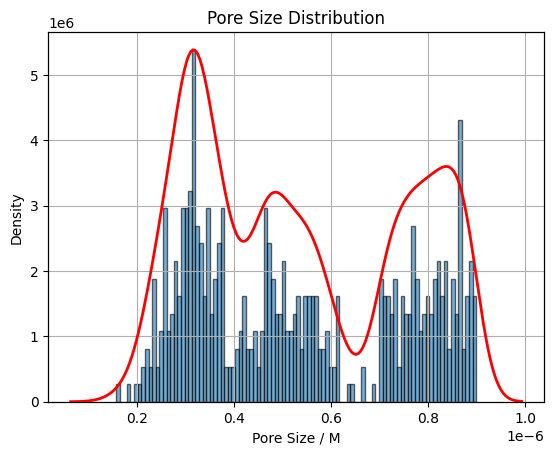

In [5]:
#plotting pore size histogram
plt.hist(microscopy_df["r"], bins=100, density=True, edgecolor='black', alpha=0.6)  # 'bins' determines the number of bins
plt.xlabel('Pore Size / M')
plt.ylabel('Density')
plt.title('Pore Size Distribution')
plt.grid(True)

#plots a curve of kde over the hisogram along with some plotting witchcraft to get rid of the tick marks and numbers for the kde plot
plt.twinx()
sns.kdeplot(microscopy_df["r"], color='r', linewidth=2, bw_adjust=0.5, ax=plt.gca())
plt.ylabel('')
plt.gca().set_yticks([])
plt.show()

# Testing Washburn Equation for Predicting Pore Size

In [6]:
#defines washburn equation in a form that calculates pore size
def calc_r_washburn(gamma, L, t, phi, eta):
    r = (2*eta*L**2)/(gamma*t*np.cos(phi))
    return r

I split the dataset into train and test sets I used seeding so all models were trained and tested on the same data to ensure the results were comparable

In [7]:
#creates X and y objects
X = microscopy_df.drop(columns=['r'])
y = microscopy_df['r'] 

#Splitsw data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#makes a new dataframe wwhich only includes the test data
microscopy_test = pd.concat([X_test, y_test], axis=1)

In [8]:
#calculates the pore sizes for the datapoints in microscopy_df
microscopy_test["washburn_predicted_r"] = calc_r_washburn(microscopy_test["gamma"], microscopy_test["L"], microscopy_test["t"], microscopy_test["phi"], microscopy_test["eta"])

A graph was plotted of the predicted values against the true values to see if this was done accuratly 

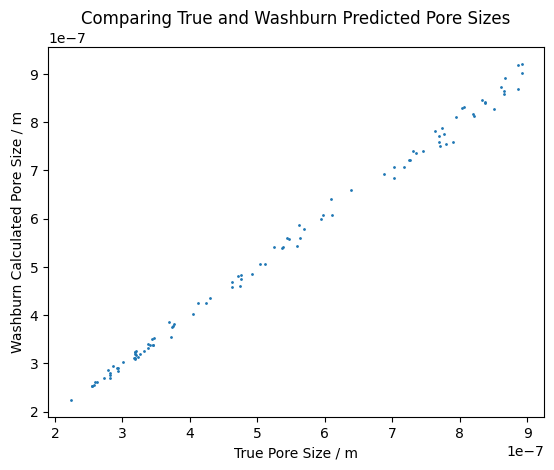

In [9]:
fig , ax = plt.subplots()

ax.scatter(microscopy_test["r"], microscopy_test["washburn_predicted_r"], s = 1)
ax.set_xlabel("True Pore Size / m")
ax.set_ylabel("Washburn Calculated Pore Size / m")
ax.set_title("Comparing True and Washburn Predicted Pore Sizes")

plt.show()

Histograms were then plotted which showed the distribution of absolute and percentage errors

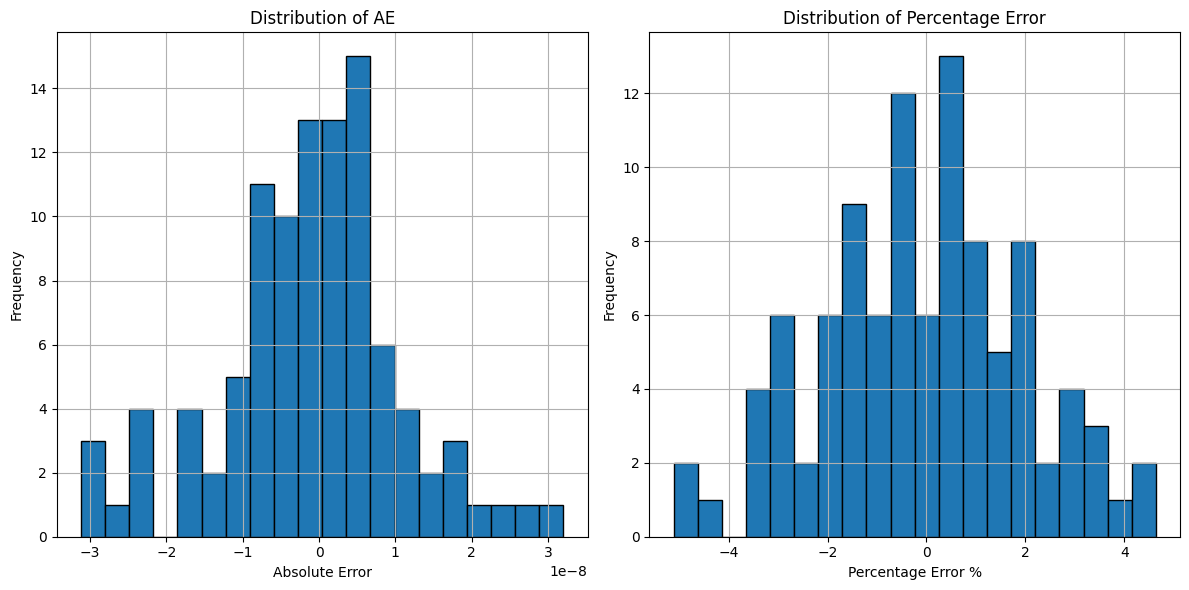

In [10]:
#calculates teh absolute error and fractional error
microscopy_test["absolute_error"] = microscopy_test["r"] - microscopy_test["washburn_predicted_r"]
microscopy_test["fractional_error"] = microscopy_test["absolute_error"] / microscopy_test["r"]

#makes the figure
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# plots abs errors
axs[0].hist(microscopy_test["absolute_error"], bins=20, edgecolor='black') 
axs[0].set_xlabel('Absolute Error')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Distribution of AE')
axs[0].grid(True)

#plots percentage errors
axs[1].hist(microscopy_test["fractional_error"]*100, bins=20, edgecolor='black')
axs[1].set_xlabel('Percentage Error %')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Distribution of Percentage Error')
axs[1].grid(True)

plt.tight_layout()
plt.show()

calculating rmse

In [11]:
#calculates the rmse and the percentage rmse
rmse = np.sqrt(mean_squared_error(microscopy_test["r"], microscopy_test["washburn_predicted_r"]))
rmse_percentage = (rmse / np.mean(microscopy_test["r"])) * 100
print(f"the rmse was {rmse}")
print(f"RMSE as a percentage: {rmse_percentage}")

the rmse was 1.1904684174617953e-08
RMSE as a percentage: 2.235725303378983


# Kernal Ridge Regression for Pore Size Prediction

In [12]:
microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


first ridge regression model

In [13]:

#creates a kernal ridge regression model
krr = KernelRidge(kernel='poly')
krr.fit(X_train, y_train)

#generates predictions
y_pred = krr.predict(X_test)

#calculates some metrics
mae = mean_absolute_error(y_test, y_pred)
print("mae:", mae)
r_squared = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rmse)

#percentage rmse
rmse_percentage = (rmse / np.mean(y_test)) * 100
print("Root Mean Squared Error (RMSE) as a percentage:", rmse_percentage)

mae: 1.2716145315750338e-07
rmse: 1.5498376156632044e-07
Root Mean Squared Error (RMSE) as a percentage: 29.10628390171448


c:\Users\benlu\newanaconda3\envs\clustering_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [14]:
microscopy_df.head()

,gamma,phi,eta,L,t,r
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07


this model was garbage :((((

I decided to investigate the scaling of the data

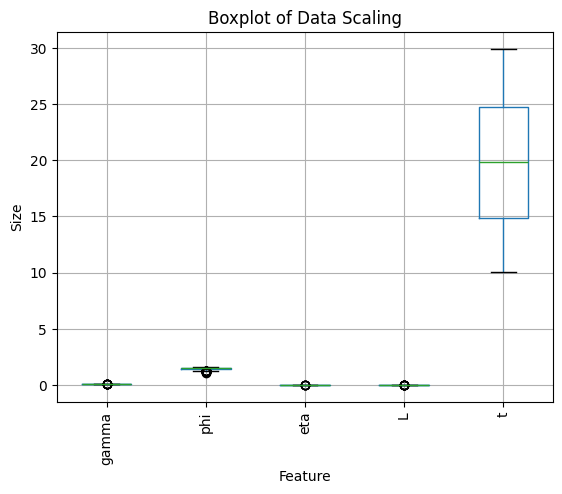

In [15]:
#makes boxplot
pd.DataFrame(microscopy_df.drop(columns=['r'])).boxplot(rot=90);
plt.xlabel("Feature")
plt.ylabel("Size")
plt.title("Boxplot of Data Scaling")
plt.show()

the data scaling drastically varied so I decided to try again but this time scaling the input data

In [16]:
#
#This time it scales the data
#

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#creates a kernal ridge regression model
krr = KernelRidge(kernel='poly')
krr.fit(X_train, y_train)

#generates predictions
y_pred = krr.predict(X_test)

#calculates some metrics
mae = mean_absolute_error(y_test, y_pred)
print("mae:", mae)
r_squared = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rmse)

#percentage rmse
rmse_percentage = (rmse / np.mean(y_test)) * 100
print("Root Mean Squared Error (RMSE) as a percentage:", rmse_percentage)

mae: 5.89007573842016e-08
rmse: 8.919841762048646e-08
Root Mean Squared Error (RMSE) as a percentage: 16.751654757937935


c:\Users\benlu\newanaconda3\envs\clustering_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


this improved things but still wasnt great next I thought I could make the trend more simple by 

In [17]:
microscopy_df["cos(phi)"] = np.cos(microscopy_df["phi"])
microscopy_df["L**2"] = microscopy_df["L"]**2

In [18]:
microscopy_df.head()

,gamma,phi,eta,L,t,r,cos(phi),L**2
0,0.084596,1.557367,0.000981,0.003221,24.231107,7.453712e-07,0.013429,1.037194e-05
1,0.064291,1.538842,0.000998,0.002395,22.169765,2.600680e-07,0.031949,5.736307e-06
2,0.086224,1.546138,0.001008,0.003036,23.257709,3.734618e-07,0.024656,9.220038e-06
3,0.082859,1.566878,0.000997,0.001261,12.717432,7.567173e-07,0.003918,1.589337e-06
4,0.090832,1.570229,0.001002,0.000576,15.189146,8.239067e-07,0.000567,3.318623e-07


In [19]:
#creates X and y objects
X = microscopy_df.drop(columns=['r', "phi", "L"])
y = microscopy_df['r'] 

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#scaling the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#creates a kernal ridge regression model
krr = KernelRidge(kernel='poly')
krr.fit(X_train, y_train)

#generates predictions
y_pred = krr.predict(X_test)

#calculates some metrics
mae = mean_absolute_error(y_test, y_pred)
print("mae:", mae)
r_squared = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rmse)

#percentage rmse
rmse_percentage = (rmse / np.mean(y_test)) * 100
print("Root Mean Squared Error (RMSE) as a percentage:", rmse_percentage)

        gamma       eta          t  cos(phi)          L**2
0    0.084596  0.000981  24.231107  0.013429  1.037194e-05
1    0.064291  0.000998  22.169765  0.031949  5.736307e-06
2    0.086224  0.001008  23.257709  0.024656  9.220038e-06
3    0.082859  0.000997  12.717432  0.003918  1.589337e-06
4    0.090832  0.001002  15.189146  0.000567  3.318623e-07
..        ...       ...        ...       ...           ...
495  0.077699  0.000989  21.967531  0.088832  3.694407e-05
496  0.067776  0.001011  18.163634  0.082410  4.349467e-05
497  0.074166  0.000997  18.000978  0.015979  9.249079e-06
498  0.081415  0.001011  19.136713  0.130513  8.316189e-05
499  0.086839  0.001007  11.393455  0.046362  9.106411e-06

[500 rows x 5 columns]
mae: 6.656502844522197e-08
rmse: 9.709639070583384e-08
Root Mean Squared Error (RMSE) as a percentage: 18.234911097485806


c:\Users\benlu\newanaconda3\envs\clustering_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


optimising hyperparameters

In [20]:
#defines pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('krr', KernelRidge())
])

#sets a bunch of parameters to be optimised
param_grid = {
    'krr__alpha': [0.01, 0.1, 0.5, 1.0, 10.0], 
    'krr__kernel': ['linear', 'rbf', 'poly'],  
    'krr__gamma': [0.01, 0.1, 1.0, 10.0],
    'krr__degree': [2, 3, 4]
}

#does the search gand prints tyeh best parameter set
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

#generates predictions with best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#calcu,ates rmse error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)
rmse_percentage = (rmse / np.mean(y_test)) * 100
print("Root Mean Squared Error (RMSE) as a percentage:", rmse_percentage)

Best Hyperparameters: {'krr__alpha': 0.01, 'krr__degree': 2, 'krr__gamma': 0.1, 'krr__kernel': 'rbf'}
Root Mean Squared Error (RMSE): 8.544322450417808e-08
Root Mean Squared Error (RMSE) as a percentage: 16.04642141062197


All prior attemps were poor so I decided to see if ML could instead be used to augment teh washburn predictions

In [21]:
#caiclulating washburn r values
microscopy_df["washburn_predicted_r"] = calc_r_washburn(microscopy_df["gamma"], microscopy_df["L"], microscopy_df["t"], microscopy_df["phi"], microscopy_df["eta"])

In [22]:
#creates X and y objects
X = microscopy_df.drop(columns=['r'])
y = microscopy_df['r'] 

print(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#creates a kernal ridge regression model
krr = KernelRidge(kernel='poly')
krr.fit(X_train, y_train)

#generates predictions
y_pred = krr.predict(X_test)

#calculates some metrics
mae = mean_absolute_error(y_test, y_pred)
print("mae:", mae)
r_squared = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("rmse:", rmse)

#percentage rmse
rmse_percentage = (rmse / np.mean(y_test)) * 100
print("Root Mean Squared Error (RMSE) as a percentage:", rmse_percentage)

        gamma       phi       eta         L          t  cos(phi)  \
0    0.084596  1.557367  0.000981  0.003221  24.231107  0.013429   
1    0.064291  1.538842  0.000998  0.002395  22.169765  0.031949   
2    0.086224  1.546138  0.001008  0.003036  23.257709  0.024656   
3    0.082859  1.566878  0.000997  0.001261  12.717432  0.003918   
4    0.090832  1.570229  0.001002  0.000576  15.189146  0.000567   
..        ...       ...       ...       ...        ...       ...   
495  0.077699  1.481847  0.000989  0.006078  21.967531  0.088832   
496  0.067776  1.488293  0.001011  0.006595  18.163634  0.082410   
497  0.074166  1.554817  0.000997  0.003041  18.000978  0.015979   
498  0.081415  1.439910  0.001011  0.009119  19.136713  0.130513   
499  0.086839  1.524417  0.001007  0.003018  11.393455  0.046362   

             L**2  washburn_predicted_r  
0    1.037194e-05          7.396247e-07  
1    5.736307e-06          2.513107e-07  
2    9.220038e-06          3.757911e-07  
3    1.589337e-

c:\Users\benlu\newanaconda3\envs\clustering_env\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


trying hyper parameter optimisation again 

In [23]:
#defines pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('krr', KernelRidge())
])

#sets a bunch of parameters to be optimised
param_grid = {
    'krr__alpha': [0.01, 0.1, 0.5, 1.0, 10.0], 
    'krr__kernel': ['linear', 'rbf', 'poly'],  
    'krr__gamma': [0.01, 0.1, 1.0, 10.0],
    'krr__degree': [2, 3, 4]
}

#does the search gand prints tyeh best parameter set
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print("Best Hyperparameters:", grid_search.best_params_)

#generates predictions with best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

#calcu,ates rmse error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)
rmse_percentage = (rmse / np.mean(y_test)) * 100
print("Root Mean Squared Error (RMSE) as a percentage:", rmse_percentage)

Best Hyperparameters: {'krr__alpha': 0.01, 'krr__degree': 2, 'krr__gamma': 0.01, 'krr__kernel': 'poly'}
Root Mean Squared Error (RMSE): 1.2340622975439755e-08
Root Mean Squared Error (RMSE) as a percentage: 2.3175955481856465


# Investigating Pore Size and Biscuit Type

In [24]:
#calculates the r values
dunking_df["predicted_r"] = calc_r_washburn(dunking_df["gamma"], dunking_df["L"], dunking_df["t"], dunking_df["phi"], dunking_df["eta"])

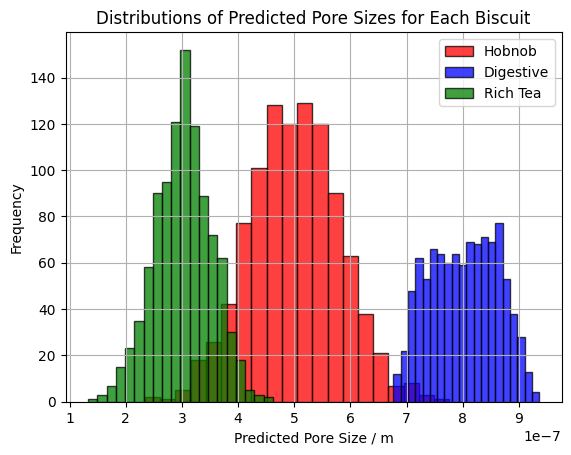

In [25]:
#plotting pore size histograms
plt.hist(dunking_df[dunking_df["biscuit"] == "Hobnob"]["predicted_r"], bins=20, color = "red", edgecolor = "black",label = "Hobnob", alpha = 0.75)
plt.hist(dunking_df[dunking_df["biscuit"] == "Digestive"]["predicted_r"], bins=20, color = "blue", edgecolor = "black", label = "Digestive", alpha = 0.75)
plt.hist(dunking_df[dunking_df["biscuit"] == "Rich Tea"]["predicted_r"], bins=20, color = "green", edgecolor = "black", label = "Rich Tea", alpha = 0.75)

plt.xlabel('Predicted Pore Size / m')
plt.ylabel('Frequency')
plt.title('Distributions of Predicted Pore Sizes for Each Biscuit')
plt.legend()
plt.grid(True)
plt.show()

# Biscuit Classification

The above plot suggested that a simple rule based approach could differentiate between biscuits based on pore size alone this is defined in the below equation 

In [26]:
#simple classifier based on the washburn calculate pore size
def basic_classifier(pore_size):
    if pore_size < 3.9*10**-7:
        return "Rich Tea"
    elif 3.9*10**-7 <= pore_size < 6.75*10**-7:
        return "Hobnob"
    else:
        return "Digestive"

In [27]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit,predicted_r
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,5.814437e-07


I split dunking into test and train sets This was so the predictions could be compared to the later machine learning models

In [28]:
X = dunking_df.drop(columns=['biscuit']) 

y = dunking_df['biscuit']  

#splits the data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#makes a new dataframe wwhich only includes the test data
dunking_test = pd.concat([X_test, y_test], axis=1)

In [29]:
dunking_test.head()

,gamma,phi,eta,L,t,predicted_r,biscuit
1801,0.079227,1.501511,0.001001,0.006075,15.175841,8.872721e-07,Digestive
1190,0.063461,1.310764,0.001002,0.007638,15.218763,4.709660e-07,Hobnob
1817,0.070570,1.404743,0.001010,0.011056,29.334502,7.218341e-07,Digestive
251,0.064774,1.556337,0.001006,0.002141,12.889326,7.640484e-07,Digestive
2505,0.053301,1.493639,0.001002,0.004728,14.681538,7.423591e-07,Digestive


the rule based method could now be used to calculate the biscuit type

biscuit
Digestive    204
Hobnob       187
Rich Tea     184
Name: count, dtype: int64
The model was: 95.83333333333334% accurate
F1 Score: 0.9581041908166069


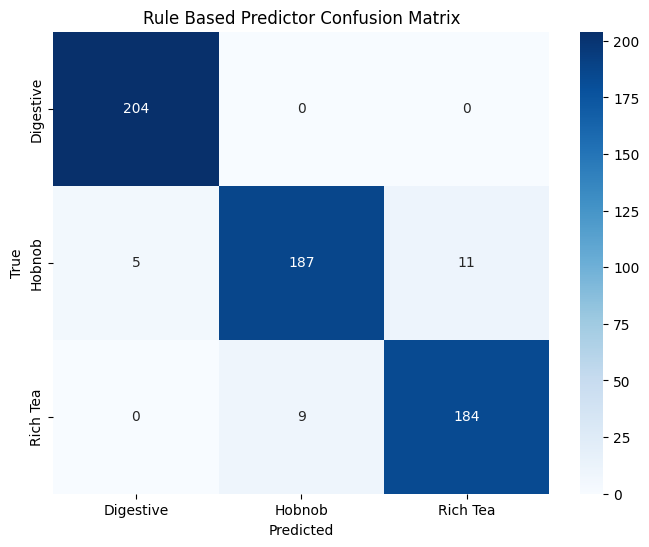

In [30]:
#makes predictions
dunking_test["basic_prediction"] = dunking_test["predicted_r"].apply(basic_classifier)

#counts how many times the prediction was correct

count_matches = dunking_test[dunking_test["biscuit"] == dunking_test["basic_prediction"]]["biscuit"].value_counts()
print(count_matches)

sum_accurate_matches = count_matches.sum()

print(f"The model was: {100*(sum_accurate_matches/(3000*0.2))}% accurate")

## making a confusion matrix and calculating the f1 score

from sklearn.metrics import f1_score, confusion_matrix

#gets true and predicted biscuit results
y_true = dunking_test["biscuit"]
y_pred = dunking_test["basic_prediction"]

#calculates f1 score
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"F1 Score: {f1}")

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=dunking_test["biscuit"].unique())

#plots seaborn heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dunking_test["biscuit"].unique(), yticklabels=dunking_test["biscuit"].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Rule Based Predictor Confusion Matrix')
plt.show()

### Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import MinMaxScaler

#scales data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#creates teh classifier
classifier = DecisionTreeClassifier()

classifier.fit(X_train, y_train)

#does predictions
y_pred = classifier.predict(X_test)

#calculates model metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1-score:", f1)
print("Classification Report:")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9166666666666666
F1-score: 0.9166607535775884
Classification Report:
              precision    recall  f1-score   support

   Digestive       0.98      0.98      0.98       204
      Hobnob       0.87      0.89      0.88       203
    Rich Tea       0.91      0.88      0.89       193

    accuracy                           0.92       600
   macro avg       0.92      0.92      0.92       600
weighted avg       0.92      0.92      0.92       600

Confusion Matrix:
[[200   4   0]
 [  5 181  17]
 [  0  24 169]]


In [32]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit,predicted_r
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,5.814437e-07


In [33]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from sklearn.metrics import accuracy_score, classification_report

c:\Users\benlu\newanaconda3\envs\clustering_env\lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.3572 - loss: 1.2380 - val_accuracy: 0.7208 - val_loss: 0.8765
Epoch 2/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5265 - loss: 0.9572 - val_accuracy: 0.7542 - val_loss: 0.7077
Epoch 3/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6149 - loss: 0.8032 - val_accuracy: 0.7979 - val_loss: 0.5734
Epoch 4/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6605 - loss: 0.7093 - val_accuracy: 0.8062 - val_loss: 0.4867
Epoch 5/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7368 - loss: 0.6049 - val_accuracy: 0.8375 - val_loss: 0.4351
Epoch 6/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7437 - loss: 0.5630 - val_accuracy: 0.8562 - val_loss: 0.4014
Epoch 7/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7721 - loss: 0.5371 - val_accuracy: 0.8771 - val_loss: 0.3779
Epoch 8/89
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7793 - loss: 0.4716 - val_accuracy: 0.8854 - val_loss:

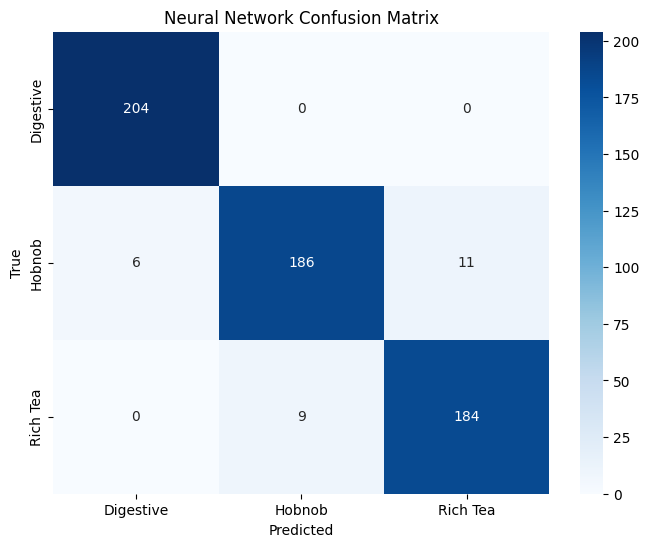

In [35]:
#makes x and y and scales data
X = dunking_df.drop(columns=['biscuit'])  # Features
y = dunking_df['biscuit']  
X = scaler.fit_transform(X)

#encodes labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
#splits data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#makes model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.7),
    Dense(64, activation='relu'),
    Dropout(0.7),
    Dense(3, activation='softmax')  # 3 classes: Hobnob, Digestive, Rich Tea
])

#complies model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#trains model
history = model.fit(X_train, y_train, epochs=89, batch_size=32, validation_split=0.2)

# Evaluate the model
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

##outputs metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 Score:", f1)
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=dunking_test["biscuit"].unique(), yticklabels=dunking_test["biscuit"].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Neural Network Confusion Matrix')
plt.show()

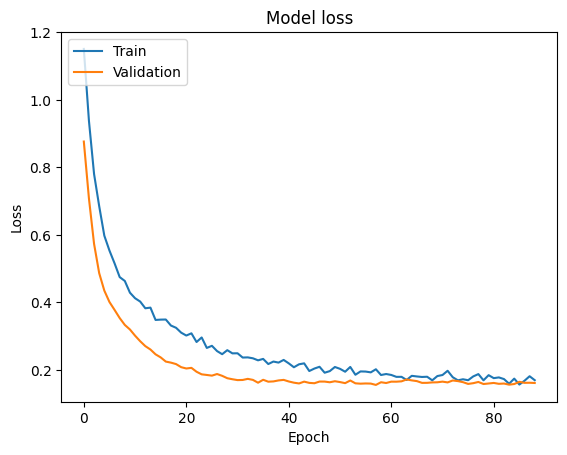

In [36]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [37]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit,predicted_r
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,5.814437e-07


In [38]:
pca = PCA(n_components=5)

principalComponents = pca.fit_transform(dunking_df.drop(columns=['biscuit']))
PCA_components = pd.DataFrame(principalComponents)

In [39]:
dunking_df.head()

,gamma,phi,eta,L,t,biscuit,predicted_r
0,0.073897,1.333006,0.000999,0.011196,19.362214,Digestive,7.429094e-07
1,0.080946,1.476758,0.001012,0.005894,11.852589,Digestive,7.803690e-07
2,0.087408,1.477141,0.000984,0.009249,24.793669,Digestive,8.302559e-07
3,0.070793,1.502001,0.001002,0.003774,16.292780,Hobnob,3.598074e-07
4,0.058917,1.548274,0.001004,0.002291,13.662271,Hobnob,5.814437e-07


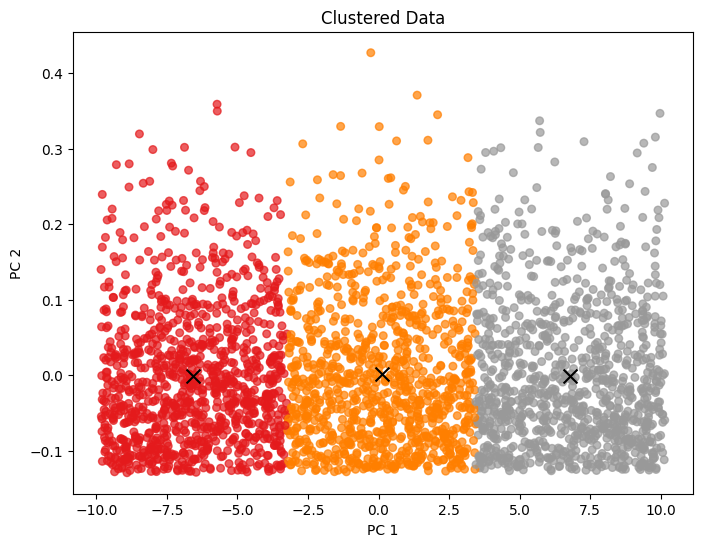

In [40]:
# Clusters the data into 3 clusters
kmeans = KMeans(n_clusters=3, init='random', random_state=5)
kmeans.fit(PCA_components.iloc[:, :6])

# Calculates centroids
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns=list(PCA_components.iloc[:, :6].columns.values))

# Plots data based on two dimensions based on its first 2 principal components
plt.figure(figsize=(8, 6))
labels = kmeans.predict(PCA_components.iloc[:, :6])
plt.scatter(PCA_components[0], PCA_components[1], alpha=0.7, c=labels, cmap='Set1', s=30)
plt.scatter(centroids_df.iloc[:, 0], centroids_df.iloc[:, 1], color='black', s=100, marker='x')
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title("Clustered Data")

plt.show()


# Predictions with TR Data

To calculate the biscuit types for the biscuit types for the time resolved data the average pore size was calculated this was then inputted into the most successful biscuit classifing function

In [41]:
#defines a function which calculates the mean pore size
def mean_pore_size(tr_df):
    output_df = pd.DataFrame({'gamma': [6.78*10**-2] * 100})
    output_df["phi"] = [1.45]*100
    output_df["eta"] = [9.93*10**-4]*100
    output_df["L"] = tr_df["L"]
    output_df["t"] = tr_df["t"]
    output_df["predicted_r"] = calc_r_washburn(output_df["gamma"], output_df["L"], output_df["t"], output_df["phi"], output_df["eta"])
    return np.mean(output_df["predicted_r"])

print(f"tr1 is a {basic_classifier(mean_pore_size(tr1_df))}")
print(f"tr2 is a {basic_classifier(mean_pore_size(tr2_df))}")
print(f"tr3 is a {basic_classifier(mean_pore_size(tr3_df))}")

tr1 is a Hobnob
tr2 is a Rich Tea
tr3 is a Digestive
